<a href="https://colab.research.google.com/github/Shrushti-2002/CodeAlpha/blob/main/Task_4_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Airline Tweets Sentiment Analysis**:


In [2]:
!pip install nltk vaderSentiment NRCLex plotly scikit-learn wordcloud

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=0ceb6296ed323a63d7ee354c2810afc0d8b6987fc8a0b01625ec3be4f962d8ec
  Stored in directory: /root/.cache/pip/wheels/1f/e8/d0/e3c3da0ef3b37ef4381dbf5c9401f3a9861a63ce221b13d8bb
Successfully built NRCLex


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#STEP 1: LOAD AIRLINE TWEETS DATASET
try:
  from google.colab import files
  print("Upload airline tweets dataset (CSV)")
  uploaded = files.upload()
  filename = next(iter(uploaded))
  df = pd.read_csv(filename)
except:
  print("Using local dataset if available...")
df = pd.read_csv('Tweets.csv') # fallback

Upload airline tweets dataset (CSV)


Saving Tweets.csv to Tweets.csv


In [6]:
print("Loaded columns: ", df.columns.tolist())

Loaded columns:  ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_created', 'tweet_location', 'user_timezone']


In [7]:
# Standardize required columns
if 'text' not in df.columns:
  df.rename(columns={'text':'text','tweet':'text','content':'text'}, inplace=True)
if 'airline' not in df.columns:
  df.rename(columns={'airline':'airline','company':'airline'}, inplace=True)

In [8]:
# STEP 2: TEXT CLEANING FUNCTION
# -------------------------------------------------------------
tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))


def clean_text(text):
  text = text.lower()
  text = re.sub(r"https?://\S+", "", text)
  text = re.sub(r"@[A-Za-z0-9_]+", "", text)
  text = re.sub(r"#[A-Za-z0-9_]+", "", text)
  text = re.sub(r"[^a-zA-Z ]", "", text)
  tokens = tokenizer.tokenize(text)
  tokens = [t for t in tokens if t not in stop_words]
  return " ".join(tokens)


df['clean_text'] = df['text'].astype(str).apply(clean_text)

In [9]:
# STEP 3: SENTIMENT ANALYSIS (VADER)
# -------------------------------------------------------------
vs = SentimentIntensityAnalyzer()


def get_sentiment_label(score):
  if score >= 0.05:
    return 'Positive'
  elif score <= -0.05:
    return 'Negative'
  else:
    return 'Neutral'


sent_scores = df['clean_text'].apply(lambda x: vs.polarity_scores(x))
df['compound'] = sent_scores.apply(lambda x: x['compound'])
df['sentiment'] = df['compound'].apply(get_sentiment_label)

In [11]:
nltk.download('punkt_tab')

# STEP 4: EMOTION DETECTION (NRCLex)
# -------------------------------------------------------------


def detect_emotions(text):
  emotion = NRCLex(text)
  return emotion.raw_emotion_scores


emotion_data = df['clean_text'].apply(detect_emotions)


# Convert emotion dicts to columns
emotion_df = emotion_data.apply(pd.Series).fillna(0)
df = pd.concat([df, emotion_df], axis=1)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
# Convert emotion dicts to columns
emotion_df = emotion_data.apply(pd.Series).fillna(0)
df = pd.concat([df, emotion_df], axis=1)

In [13]:
# STEP 5: SENTIMENT DISTRIBUTION VISUALIZATION (PLOTLY)
# -------------------------------------------------------------
fig_sent = px.pie(df, names='sentiment', title='Sentiment Distribution of Airline Tweets',
color='sentiment',
color_discrete_map={'Positive':'green','Neutral':'gray','Negative':'red'})
fig_sent.show()

In [14]:
# STEP 6: SENTIMENT BY AIRLINE
# -------------------------------------------------------------
fig_airline = px.bar(df.groupby(['airline','sentiment']).size().reset_index(name='count'),
x='airline', y='count', color='sentiment', barmode='group',
title='Sentiment by Airline')
fig_airline.show()

In [15]:
# STEP 7: EMOTION FREQUENCY BAR CHART
# -------------------------------------------------------------
emotion_totals = emotion_df.sum().sort_values(ascending=False)


fig_emotion = px.bar(x=emotion_totals.index, y=emotion_totals.values,
title='Dominant Emotions Across Airline Tweets',
labels={'x':'Emotion', 'y':'Count'})
fig_emotion.show()

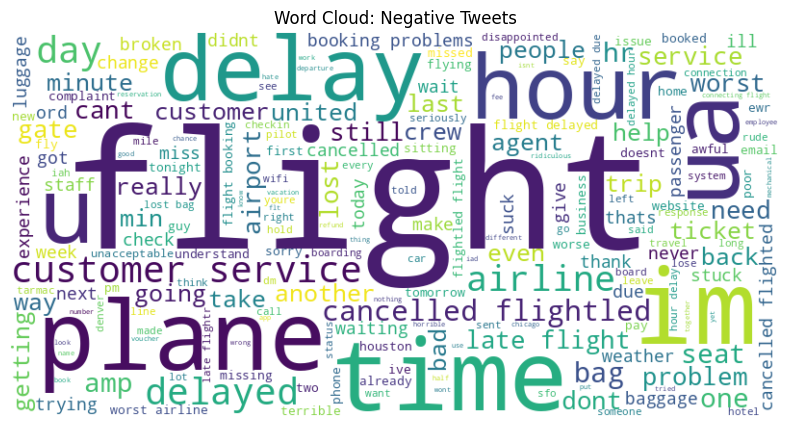

In [17]:
# STEP 8: WORD CLOUDS FOR EACH SENTIMENT
# -------------------------------------------------------------
for sentiment_type in ['Positive','Neutral','Negative']:
  subset = " ".join(df[df['sentiment']==sentiment_type]['clean_text'])
  wc = WordCloud(width=800,height=400,background_color='white').generate(subset)


plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.title(f"Word Cloud: {sentiment_type} Tweets")
plt.axis('off')
plt.show()

In [21]:
# STEP 9: INTERACTIVE DASHBOARD UI USING PLOTLY SUBPLOTS
# -------------------------------------------------------------
from plotly.subplots import make_subplots


fig_dashboard = make_subplots(rows=2, cols=2,
subplot_titles=("Sentiment Distribution", "Sentiment by Airline",
"Emotion Totals", "Compound Score Histogram"),
specs=[[{'type':'domain'}, {'type':'xy'}],
       [{'type':'xy'}, {'type':'xy'}]])


# Pie chart
pie_chart = px.pie(df, names='sentiment', color='sentiment').data[0]
fig_dashboard.add_trace(pie_chart, row=1, col=1)


# Bar chart
bar_chart = px.bar(df.groupby(['airline','sentiment']).size().reset_index(name='count'),
x='airline', y='count', color='sentiment').data
for trace in bar_chart:
  fig_dashboard.add_trace(trace, row=1, col=2)


# Emotion chart
emotion_chart = px.bar(x=emotion_totals.index, y=emotion_totals.values).data[0]
fig_dashboard.add_trace(emotion_chart, row=2, col=1)


# Histogram of compound scores
hist_chart = px.histogram(df, x='compound', nbins=30).data[0]
fig_dashboard.add_trace(hist_chart, row=2, col=2)


fig_dashboard.update_layout(height=900, width=1200, title_text="Airline Tweets Sentiment Dashboard")
fig_dashboard.show()